## import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import gym
import warnings
from typing import List
warnings.filterwarnings('ignore')
from tilecoding import TileCoder

## set environment

In [28]:
# use gym environment
env=gym.make('MountainCar-v0')


## use Tilecoding to state repsentation

In [3]:
# tile coder class takes states and returns feature representation of those
class tile_coder_():
    def __init__(self,num_tilings,tiles_per_dim):  
        # specifies tiles per dimention
        tiles_per_dim=tiles_per_dim
        # specify limitatons of each dimention
        dim_limits=[(-1.2,0.6),(-0.07,0.07)] # position limitation , velocity limitation
        # specify number of tilings
        tilings=num_tilings
        # instantiate TileCode
        self.tile_coder=TileCoder(tiles_per_dim,dim_limits,tilings)
    def tilecoder(self,state:List):
        return self.tile_coder[state[0],state[1]]


## one-step semi-gradient SARSA

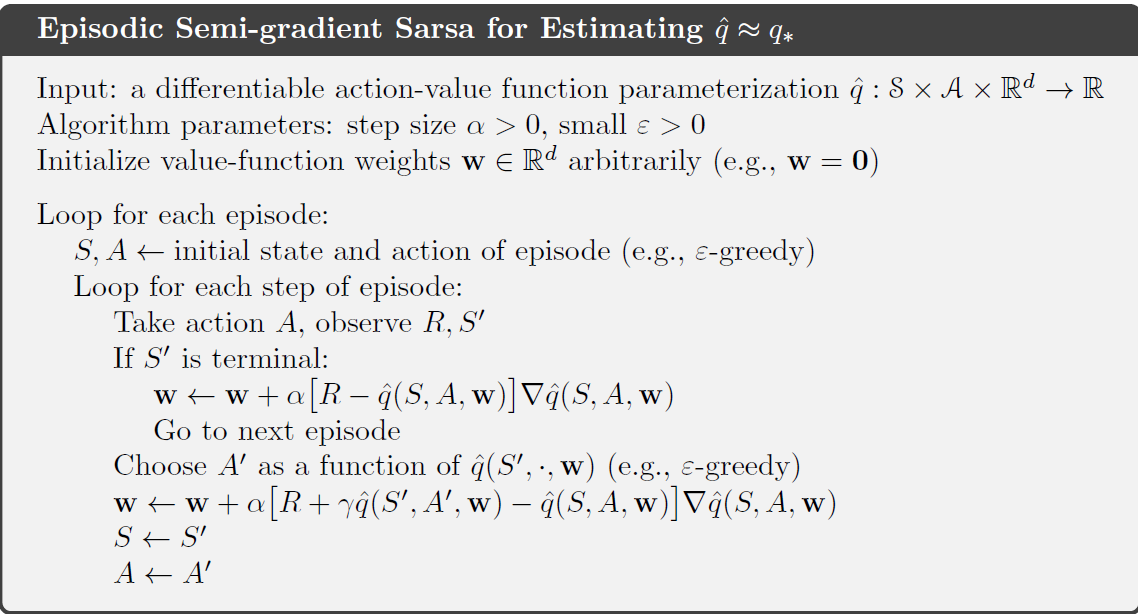

In [70]:
class semi_gradient_sarsa():
    def __init__(self,env,max_steps_per_episode,epsilon,num_tiling,step_size,discount_factor,tiles_per_dim):
        self.env=env
        self.env._max_episode_steps=max_steps_per_episode
        self.learning_rate=step_size/num_tiling
        self.discount_factor=discount_factor
        #self.num_tiling=num_tiling
        tiles_perdim=[10,10]
        self.max_size=(tiles_perdim[0]+1)*(tiles_perdim[1]+1)*num_tiling
        self.epsilon=epsilon
        #print(tiles_perdim)
        self.tile_coder=tile_coder_(num_tiling,tiles_per_dim)
        self.q_values=defaultdict(float)
        # set one seprate weight for each action
        self.w_a=np.zeros(shape=(3,self.max_size))

    def q_value_calculator(self,state,action):
        '''tile coding builds a binary representation of the states
        so action value will be calculated by  summation  of the weights indicated by tile numbers.
        action_value_function=sum(action weights (coded state))'''

        tiled_state=self.tile_coder.tilecoder(state)
        return np.sum(self.w_a[action,tiled_state])
    def epsilon_greedy(self,state):
        '''takes state and returns action according to e-greedy policy
        according to the input state'''
        # explores with probability of epsilon
        if np.random.rand(1)[0]< self.epsilon:
            action= np.random.choice(range(0,3))
        # greedy to action state value function
        else:
            q_list=[]
            for action in range(0,3):
                q_values=self.q_value_calculator(state,action)
                q_list.append(q_values)
            action=np.argmax(q_list)
        return action 
    # train agent            
    def trainer(self,num_episodes):
        step_per_episode=[]
        for episode in range(num_episodes):
            step_counter=0
            # initialize state and action
            initial_state=self.env.reset()
            action=self.epsilon_greedy(initial_state)
            done=False
            while done==False:
                step_counter+=1
                next_state,reward,done,_=self.env.step(action)
                # update if next state is terminal state
                if done ==True:
                    
                    # update weights associated with selected action (a)
                    self.w_a[action,self.tile_coder.tilecoder(initial_state)]+=self.learning_rate*(reward-self.q_value_calculator(initial_state,action))
                    
                else:
                    
                    next_action=self.epsilon_greedy(next_state)
                    self.w_a[action,self.tile_coder.tilecoder(initial_state)]+=self.learning_rate*(reward+self.discount_factor*\
                                                                                                   self.q_value_calculator(next_state,next_action)\
                                                            -self.q_value_calculator(initial_state,action))
                initial_state=next_state
                action=next_action

            step_per_episode.append(step_counter)
            
        return step_per_episode
        

        
    

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:41<00:00, 33.86s/it]


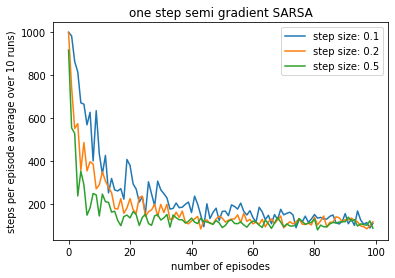

In [73]:
def runner(num_runs,num_episodes):
    
    for step_size in tqdm([0.1,0.2,0.5]):
        run_result=np.zeros(shape=(num_episodes,))
        for run in range(num_runs):
            agent=semi_gradient_sarsa(env,1000,0.1,8,step_size,1,[5,5])
            step_per_episode=agent.trainer(num_episodes=num_episodes)
            run_result+=np.array(step_per_episode)
        plt.plot(run_result/num_runs,label=f'step size: {step_size}')
    plt.legend()
    plt.title('one step semi gradient SARSA')
    plt.xlabel('number of episodes')
    plt.ylabel(f'steps per episode average over {num_runs} runs)')
    plt.savefig('one step semi gradient SARSA')
    plt.show()
runner(10,100)

In [63]:
np.array([1,2,3])+np.array([4,5,6])

array([5, 7, 9])

## n-step semi-gradient SARSA

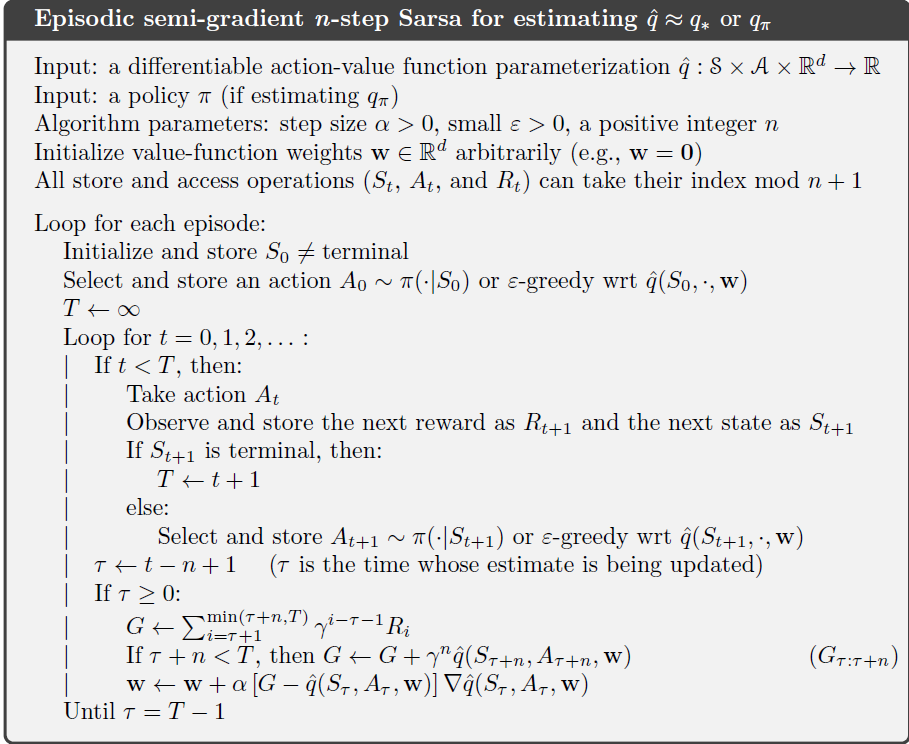

In [76]:
class n_step_semi_gradient_sarsa():
    def __init__(self,env,max_steps_per_episode,epsilon,num_tiling,step_size,discount_factor,tiles_per_dim,n_step):
        self.env=env
        # set maximum steps per episode
        self.env._max_episode_steps=max_steps_per_episode
        self.learning_rate=step_size/num_tiling
        self.discount_factor=discount_factor
        #self.num_tiling=num_tiling
        tiles_perdim=[10,10]
        self.max_size=(tiles_perdim[0]+1)*(tiles_perdim[1]+1)*num_tiling
        self.epsilon=epsilon
        #print(tiles_perdim)
        self.tile_coder=tile_coder_(num_tiling,tiles_per_dim)
        self.q_values=defaultdict(float)
        # set one seprate weight for each action
        self.w_a=np.zeros(shape=(3,self.max_size))
        self.n=n_step
    def q_value_calculator(self,state,action):
        '''tile coding builds a binary representation of the states
        so action value will be calculated by  summation  of the weights indicated by tile numbers.
        action_value_function=sum(action weights (coded state))'''

        tiled_state=self.tile_coder.tilecoder(state)
        return np.sum(self.w_a[action,tiled_state])
    
    def epsilon_greedy(self,state):
        if np.random.rand(1)[0]< self.epsilon:
            action= np.random.choice(range(0,3))
        else:
            q_list=[]
            for action in range(0,3):
                q_values=self.q_value_calculator(state,action)
                q_list.append(q_values)
            action=np.argmax(q_list)
        return action 

    def return_calculator(self,taw,T,rewards):
        G=0
        for i in range(taw+1,min(T,taw+self.n)+1):
            G+=self.discount_factor**(i-taw-1)*rewards[i]
        return G

    def trainer(self,num_episodes):
        step_per_episode=[]
        for episode in range(num_episodes):
            states=[]
            actions=[]
            rewards=[]
            # set R(0) to zero because we don't have R(0) index of rewards begins from 1  
            rewards.append(0)

            step_counter=0
            # select initial state
            initial_state=self.env.reset()
            # select action according to initial state
            initial_action=action=self.epsilon_greedy(initial_state)
            # store S(0)
            states.append(initial_state)
            # store A(0) 
            actions.append(initial_action)
            # set T to infinity
            T=float('inf')
            # iterate over t:0,1,2,...
            t=0
            while True:
                
                step_counter+=1
                if t<T:
                    
                    # take A(t) 
                    next_state,reward,done,_=self.env.step(actions[t])
                    # store R(t+1) , S(t+1)
                    rewards.append(reward)
                    states.append(next_state)
                    # if next state is terminal state
                    if done ==True:
                        T=t+1
                        
                    # if next state is not terminal state
                    else:
                        # take and store A(t+1) w.r.t S(t+1)
                        next_action=self.epsilon_greedy(states[t+1])
                        actions.append(next_action)
                taw=t-self.n+1
                if taw>=0:
                    # calculate return for "n" next steps
                    G=self.return_calculator(taw,T,rewards)
                    # add value of "n" next step to TD target
                    if taw+self.n<T:
        
                        G+=(self.discount_factor**self.n)*self.q_value_calculator(states[taw+self.n],actions[taw+self.n])
                    # update weights of (A(taw),S(taw)) with respect to value of (A(taw+n),S(taw+n)) and obtained return
                    self.w_a[actions[taw],self.tile_coder.tilecoder(states[taw])]+=self.learning_rate\
                    *(G-self.q_value_calculator(states[taw],actions[taw]))
                    
                    # update weights associated with selected action (a)
                    
                if taw==T-1:
  
                    break
                t+=1    

            step_per_episode.append(step_counter)
            
        return step_per_episode
        

        


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:02<00:00, 40.88s/it]


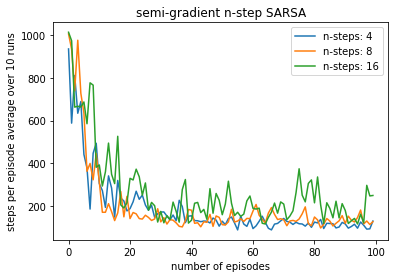

In [78]:
def runner(num_runs,num_episodes):
    
    for n in tqdm([4,8,16]):
        run_result=np.zeros(shape=(num_episodes,))
        for run in range(num_runs):
            agent=n_step_semi_gradient_sarsa(env=env,max_steps_per_episode=1000,epsilon=0.1,num_tiling=8,step_size=0.4
                                 ,discount_factor=0.99,tiles_per_dim=[10,10],n_step=n)
            step_per_episode=agent.trainer(num_episodes=num_episodes)
            run_result+=np.array(step_per_episode)
        plt.plot(run_result/num_runs,label=f'n-steps: {n}')
    plt.legend()
    plt.title('semi-gradient n-step SARSA')
    plt.xlabel('number of episodes')
    plt.ylabel(f'steps per episode average over {num_runs} runs')
    plt.savefig('semi-gradient n-step SARSA')
    plt.show()
runner(10,100)